<a href="https://colab.research.google.com/github/Gauthameshwar/RAQS_QuantumInspiredAlgos/blob/master/notebooks/RSVDnDataCompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Randomized SVD → Tensor Networks for Data Compression

**Notebook author:** Gauthameshwar Sundaravadivel

---


> **You’ll learn**
> - **Randomized SVD (RSVD)**: faster than classical SVD; power/subspace iterations for accuracy.
> - **Tensor-Train (TT/MPS)**: compress multiway data with small ranks.
> - **Case study**: gene-expression compression with TT.
>
> **Prerequisites:** Linear algebra, basic Julia.


---

<details>
  <summary>Outline (click to expand)</summary>

  1. SVD recap → low-rank ≈ compression  
  2. RSVD algorithm, complexity & error, power iterations  
  3. Tensor networks (MPS/TT) without physics baggage  
  4. TT-SVD (Oseledets) and where RSVD slots in  
  5. Gene-expression compression mini-project  
</details>

---

**Prerequisites:** Linear algebra, basic Julia.

## 0. Setup

We borrow the package deps for this notebook from the home GitHub repo of this notebook, and activate it before diving into the exercises.

In [9]:
const USER = "Gauthameshwar"
const REPO = "RAQS_QuantumInspiredAlgos"
const BRANCH = "master"

cd("/content")

if !isdir(REPO)
  run(`git clone --depth 1 -b $BRANCH https://github.com/$USER/$REPO.git`)
end

import Pkg
proj = joinpath("/content", REPO, "env")  # where Project.toml lives
isfile(joinpath(proj, "Project.toml")) || error("Project.toml not found: $proj")
Pkg.activate(proj)
Pkg.instantiate()   # uses Manifest.toml if present; pins exact versions

# proj = joinpath(pwd(), "notebooks", "env") # e.g., .../notebooks/env/Project.toml
# isdir(proj) || error("Project path not found: $proj") Pkg.activate(proj)


  Activating project at `/content/RAQS_QuantumInspiredAlgos/env`


In [124]:
using LinearAlgebra, Random # for performing SVD and writing RSVD code
using Logging, Suppressor, Printf # for tidying up the output cells
using Images, JLD2, Plots, LaTeXStrings # for image and file handling and plotting

## 1. Randomised SVD

---
> **Motivation**
>
> Many real datasets(images, audio, experimental measurements) can often be described well with only a **few important directions (singular vectors)**. That means the matrix is **approximately low rank**. A full SVD finds _all_ directions and can be slow on big matrices. RSVD focuses on the important part first, so it's **much faster** when you only need the top $k$ components

---

> **Idea in a nutshell**
>
> Instead of SVD-ing a big matrix $A$, we first find a small **orthonormal basis $Q$** that spans (most of) the columns of $A$. Then we SVD a **small matrix $B=Q^TA$** and lift the result back with $Q$.

---

Quick notation and definitions:

- Matrix $A\in \mathbb{R}^{m\times n}$: A grid of numbers with $m$ rows and $n$ columns.
- Rank $k$: How many important directions (singular vectors) we wish to keep.
- Orthonormal basis $Q\in \mathbb{R}^{m\times l}$: Columns of $Q$ are unit-length and mutually perpendicular.
- SVD: Factorisation of the matrix into $A = U \Sigma V^T$ such that $U \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ are orthonormal matrices, and $\Sigma \in \mathbb{R}^{m\times n}$ is a diagonal matrix with the singular values as its diagonal entries (from largest to smallest in magnitude).
- Oversampling parameter $p$: Additional number of rank into the sampling so we don't miss important information in the last singular vectors (optimal values around 5-20).
- Power iterations $q$: Extra passes of the subspace so we sharpen the accuracy of the singular values and its vectors.


In a standard SVD, given a matrix $A\in \mathbb{R}^{m\times n}$, we compute
$$
A = U \Sigma V^T.
$$
The best algorithm of SVD in Julia is provided by `LinearAlgebra`'s `LAPACK` support which has the runtime complexity of
$$
O(mn\times \text{min}(m, n)).
$$
This can get slow when both $m$ and $n$ are large. In the worst case scenario, where we have a large square matrix, the complexity scales as $O(n^3)$.

Also, the memory complexity of performing the SVD goes as
$$
O(mn + m^2 + n^2),
$$ which is quadratic in the largest size.

### The RSVD algorithm

> Goal: To get a good rank‑$k$ approximation quickly by working with a randomised subspace.

Stage A — Find a good basis

1. Make a random test matrix  with $\Omega \in \mathbb{R}^{n\times l}$ with $l = k + p$.

2. Form a sample of $A$’s column space: $Y = A\Omega \in \mathbb{R}^{m\times l}$.

3. Compute a thin QR of $Y$: $Y = QR$. Keep $Q \in \mathbb{R}^{m\times l}$.

Stage B — Work in small coordinates

4. Compress $A$ to a small matrix: $B = Q^TA \in \mathbb{R}^{l\times n}$.

5. Do SVD on the small matrix: $B = \tilde{U}\Sigma V^T$.

6. Map back: $U \approx Q \tilde{U}$.

7. Truncate to rank $k$: keep the first $k$ columns of $U$ and $V$, and the first $k$ values in $\Sigma$.

Optional accuracy boost (power iterations): if the singular values don’t drop quickly, repeat extra multiplies $q$ times so the important directions stand out more.

### The RSVD algorithm (Halko–Martinsson–Tropp)

**Inputs**
- Matrix \(A\in\mathbb{R}^{m\times n}\)
- Target rank \(k\)
- Oversampling \(p\ge 0\) and \(\ell = k+p\)
- (Optional) Power iterations \(q\ge 0\)

**Outputs**
- \(U_k\in\mathbb{R}^{m\times k}\), \(\Sigma_k\in\mathbb{R}^{k\times k}\), \(V_k\in\mathbb{R}^{n\times k}\) such that \(A \approx U_k \Sigma_k V_k^\top\)

**Algorithm (two–stage)**

**Stage A — Randomized range finder**
1. Draw a test matrix $\Omega \in \mathbb{R}^{n\times \ell}$ (e.g., i.i.d. Gaussian).
2. Form the sample matrix $Y = A\,\Omega \in \mathbb{R}^{m\times \ell}$.
3. Compute a thin QR of $Y$: $Y = Q R$. Keep $Q \in \mathbb{R}^{m\times \ell}$.

**Stage B — Work in small coordinates**
4. Compress to a small matrix: \(B = Q^\top A \in \mathbb{R}^{\ell\times n}\).
5. Compute a thin SVD of \(B\): \(B = \tilde U\,\Sigma\,V^\top\).
6. Lift left singular vectors: \(U \gets Q\,\tilde U\).
7. **Truncate to rank \(k\)**: set \(U_k = U_{:,1:k}\), \(\Sigma_k = \Sigma_{1:k,1:k}\), \(V_k = V_{:,1:k}\).

**Optional accuracy boost (power scheme)**
- If singular values decay slowly, apply \(q\) subspace iterations before Step 3:
  - Initialize \(Y_0 = A\,\Omega\).
  - For \(i=1,\dots,q\):
    - Orthonormalize \(Y_{i-1}\) to \(Q\) (thin QR).
    - Set \(Z = A^\top Q\), orthonormalize \(Z\) to \(Q_z\).
    - Set \(Y_i = A\,Q_z\).
  - Finally, set \(Y \gets Y_q\) and proceed with Step 3.


In [90]:
function rsvd(
    A::AbstractMatrix{<:Union{Real, Complex}}, 
    l::Int;
    
    p::Int=10, 
    rng=Random.default_rng(), 
)
    m, n = size(A)
    @info "Starting Randomized SVD" DataSize=(m, n) RequestedSingularValues=l OversamplingParameter=p TotalColumnsForSampling=(l+p)

    # sample a random matrix Y in the subspace of A
    @info "1. Sampling random matrix Y..."
    time_Y = @elapsed Y = A * randn(rng, n, l)

    @info "Y sampling completed" Time=time_Y

    # form the sample matrix B
    @info "2. Performing QR factorization of Y and forming sample matrix B..."
    time_B = @elapsed Q = qr(Y).Q[:, 1:min(l+p, size(qr(Y).Q, 2))]
    B = Q' * A
    @info "B formation completed" Time=time_B

    # compute the SVD of B
    @info "3. Computing the SVD of B..."
    time_svd_B = @elapsed Ũ, D, V = svd(B)
    @info "SVD of B completed" Time=time_svd_B

    # compute the approximate singular vectors of A
    @info "4. Computing the approximate singular vectors of A..."
    time_U = @elapsed U = Q * Ũ[:, 1:l]
    @info "Approximate U computation completed" Time=time_U

    @info "Randomized SVD completed"

    return U[:, 1:l], D[1:l], V[:, 1:l]
end


rsvd (generic function with 2 methods)

### Runtime and memory complexity of RSVD
1. Runtime
- The heavy work in this algorithm is done in the largest matrix multiplications: $Y = A \Omega$. When the matrix is dense (worst-case scenario), it has a rough cost of $O(mnl)$.

- The QR and SVD has $O(ml^2 + nl^2)$ together. Thus, they are not the bottleneck of this algorithm for small values of $l$.

2. Memory
- Excluding the storing of the original data $A$, the memory complexity of RSVD is $O((m + n)l)$.
- This makes it more memory efficient for larger data sizes than SVD since it scales linearly in the largest dimension.

In [99]:
# --- Reproducible seed ---------------------------------------------------------
seed = 20250911               # Date of the notebook, you can pick any integer you like
rng  = MersenneTwister(seed)  # local RNG

# Measure a function once, capturing time/GC/bytes (not printing its return)
function bench(name, f)
    GC.gc()  # reduce noise from previous allocations
    result = @timed f()
    (; name,
       time_s = result.time,
       gc_s   = result.gctime,
       mem_MB = round(result.bytes / 1024^2; digits=2))
end

# --- Warm-up small ops to avoid counting compilation time ---------------------
rsvd(randn(rng, 1000, 1000), 20)
svd(randn(rng, 1000, 1000))

m, n = 5000, 5000                # NOTE: this is heavy; reduce if your RAM/CPU is limited
A = randn(rng, m, n)

k = 100                          # target rank for RSVD
results = [
    bench("RSVD(k=$k)",      () -> @suppress rsvd(A, k)),
    bench("SVD", () -> svd(A))
]

# --- Pretty table -------------------------------------------------------------
println("\nResults  (seed=$seed, size=$(m)x$(n))")
@printf("%-18s %10s %10s %12s\n", "Method", "time[s]", "gc[s]", "bytes[MB]")
for r in results
    @printf("%-18s %10.3f %10.3f %12.2f\n", r.name, r.time_s, r.gc_s, r.mem_MB)
end


┌ Info: Starting Randomized SVD
│   DataSize = (1000, 1000)
│   RequestedSingularValues = 20
│   OversamplingParameter = 10
│   TotalColumnsForSampling = 30
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:3
┌ Info: 1. Sampling random matrix Y...
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:6
┌ Info: Y sampling completed
│   Time = 0.021412834
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:8
┌ Info: 2. Performing QR factorization of Y and forming sample matrix B...
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:11
┌ Info: B formation completed
│   Time = 0.000879292
└ @ Main /Users/gau


Results  (seed=20250911, size=5000x5000)
Method                time[s]      gc[s]    bytes[MB]
RSVD(k=100)             0.120      0.003        47.03
SVD                    17.127      0.013      1145.11


We can see a clear advantage of RSVD over SVD when we deal with very large matrices where both $m$ and $n$ are large. 

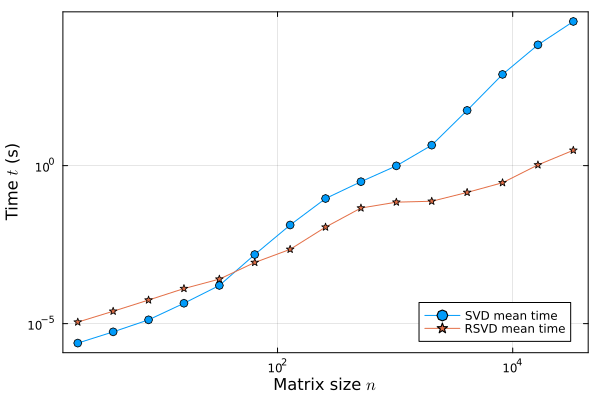

RSVD runtime for 2^15 × 2^15 matrix: 3.058564145 seconds
SVD runtime for 2^15 × 2^15 matrix: 36328.428318361 seconds


In [126]:
# load the benchmark_ data
cd("/Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos")
@load "assets/benchmark_data.jld2" time_svd_mean time_rsvd_mean

n = size(time_svd_mean, 1)

sizes = [2^i for i in 1:n]

# Plot the results
fig = plot(
    sizes, 
    time_svd_mean, 
    xscale=:log10, 
    yscale=:log10, 
    label="SVD mean time", 
    xlabel="Matrix size "*L"n", 
    ylabel="Time "*" (s)", 
    legend=:bottomright, 
    marker=:o,
    frame=:box,
)
plot!(fig, 
    sizes, 
    time_rsvd_mean, 
    label="RSVD mean time", 
    marker=:s
)

display(fig)

println("RSVD runtime for 2^15 × 2^15 matrix: $(time_rsvd_mean[end]) seconds")
println("SVD runtime for 2^15 × 2^15 matrix: $(time_svd_mean[end]) seconds")


### Accuracy of RSVD

RSVD is essentially a $k$-rank approximation of the original matrix $A$ since we just compute the top $k$ singular values and vectors in the step 7. The accuracy of this algorithm is given by a lower bound (Eckart-Young)
$$
|| A - Q.Q^T.A || \geq \underset{\textrm rank(X)\leq l}{min} ||A - X || = σ_{l+1}. 
$$
In other words, it says an SVD truncated to $k$ singular values is the best k-rank approximation of our data. 

However, in practice, when we run the RSVD algorithm, the error is usually larger than this lower bound. 

To illustrate this, we take an example of a Gray-scale image to depict our data matrix $A$ with float values corresponding to the pixel intensities. 

  Activating project at `~/Documents/VSCode/RAQS_QuantumInspiredAlgos/env`
┌ Info: Image loaded
│   Size = (225, 225)
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:9


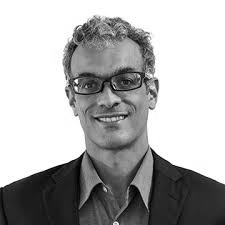

In [104]:
# If running on local repo
cd("..")
using Pkg; Pkg.activate("/Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/env/Project.toml")

# img = load(joinpath("/content", REPO, "data", "ShoreTemple.jpeg"))
img = load("/Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/assets/Dario.jpeg") # If running on local repo
# img = load(joinpath("/content", REPO, "assets", "Dario.jpeg")) # If running on collab

@info "Image loaded" Size=size(A)
println()

img = Gray.(img)

In [128]:
A = Float64.(img)

# The number of singular values to compute
k = 32

# Compute the k-rank SVD of A
println("Computing the SVD of A...")
@time U, D, V = svd(A)
# Keep only the top k singular values/vectors in the original SVD and the rest is 0 in D
D = vcat(D[1:k], zeros(min(size(A)...)-k))
println()

# Compute the RSVD of A
println("Computing the RSVD of A...")
# make the rsvd function's output quiet
@time @suppress Ũ, D̃, Ṽ = rsvd(A, k)
println()

# Compute the approximation error
println("Relative error of SVD: ", norm(A - U * Diagonal(D) * V') / norm(A))
println("Relative error of RSVD: ", norm(A - Ũ * Diagonal(D̃) * Ṽ') / norm(A))

Computing the SVD of A...
  0.012187 seconds (22 allocations: 2.423 MiB)

Computing the RSVD of A...
  0.011520 seconds (2.05 k allocations: 1.223 MiB, 80.76% compilation time)

Relative error of SVD: 0.04460721478093183
Relative error of RSVD: 0.06355742525533889


The error of RSVD is more than that of a $k$-rank SVD, although close. This can be seen in the singular value spectrum as the inaccuracies present in the edge of the spectrum. It can also be seen in the picture we regenerate from the RSVD data compared to the SVD one.

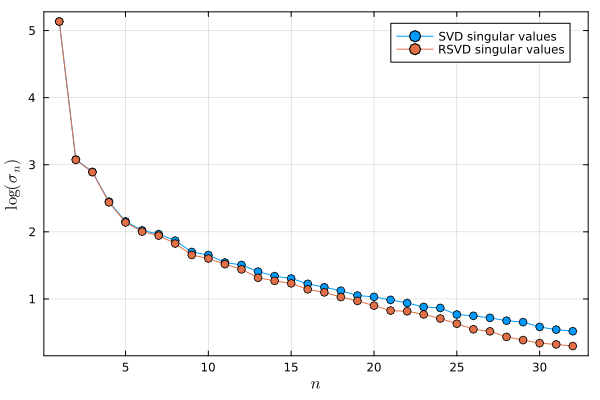

In [131]:
# plot the singular values of img obtained from SVD and RSVD
plot(
    1:k, 
    log.(D), 
    label="SVD singular values", 
    xlabel=L"n", 
    ylabel=L"\textrm{log}(σ_n)", 
    legend=:topright, 
    marker=:o, 
    frame=:box,
)
plot!(log.(D̃), label="RSVD singular values", marker=:o, )

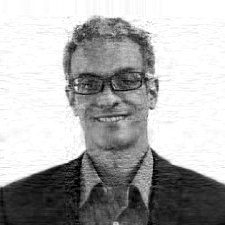

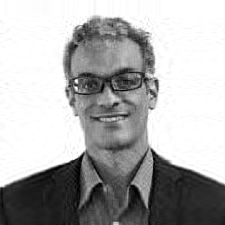

RSVD image
SVD image


In [47]:
println("RSVD image")
display(Gray.(Ũ * Diagonal(D̃) * Ṽ'))

println("SVD image")
display(Gray.(U * Diagonal(D) * V'))

### Power/subspace iterations

The error of the RSVD is accumulated in the smaller singular values and their corresponding singular vectors. This is especially pronounced in data where the singular values don't drop quick and have a "flat" spectrum. We can try to reduce this error by increasing the oversampling parameter $p$ to sample more singular values and vectors. This only reduces the error slightly, and worse, it comes at the cost of increased complexity of the algorithm since the complexity scales as $O(mnl)$ where $l = k + p$. 

Fortunately, we can do better than this in our RSVD without increasing the runtime complexity. Power iterations help us sharpen the singular values and vectors by effectively power-decaying the singular value spectrum that we will be sampling from. In the power iteration step, we do the following:

1. Make a random test matrix with $\Omega \in \mathbb{R}^{n\times l}$ with $l = k + p$.

2. Instead of defining $Y = A.Ω$, we define $Y = (A.A^T)^q. A.Ω$ where $q$ is the number of power iterations we wish to do.

3. \- 7. Same as the origina RSVD.

This step in going to the subspace of $(A.A^T)^q. A$ significantly reduces the errors arising from the smaller singular values in the singular vectors since the singular values are raised to the power $2q+1$ and now decay much more quickly. The singular vectors remain the same as $A$. If $A$ can be written in the SVD form as $A =  UDV^†$, then $\left( AA^T\right)^q A$ can be written as
$$
\left( AA^T\right)^q A =  U  D^{2q+1} V^†.
$$

This makes the SVD step more accurate than that without the subspace iteration. 

In practice, $q = 2-5$ will be enough to bring the error closer to the lower bound. Thus, this power iteration does not increase the complexity of the algorithm for small values of $q$ since the matrix multiplications are still dominated by the $O(mnl)$ term. It also avoids increasing $l$ to get a better accuracy of the previous singular values, which would have increased the complexity.


In [132]:
"""
    rsvd(A, k; p=10, q=0, rng=Random.default_rng(), verbose=false)

Randomized SVD (Halko–Martinsson–Tropp) with optional subspace/power iterations.

Inputs
  A   :: AbstractMatrix{<:Real,<:Complex>}
  k   :: Int                # target rank
  p   :: Int = 10           # oversampling (ℓ = k + p)
  q   :: Int = 0            # power/subspace iterations, 0–2 common
  rng :: AbstractRNG        # reproducible randomness
  verbose :: Bool = false   # print @info progress

Returns
  U :: m×k, S :: Vector{<:Real} length k, V :: n×k
"""
function rsvd(
    A::AbstractMatrix{<:Union{Real, Complex}}, 
    k::Int; 

    p::Int=10, 
    q::Int=0,
    rng=Random.default_rng(), 
    verbose::Bool=false
)
    m, n = size(A)
    l = min(k + p, min(m, n))
    verbose &&  @info "Starting Randomized SVD" DataSize=(m, n) RequestedSingularValues=l OversamplingParameter=p TotalColumnsForSampling=(l+p)

    # 1) Random test matrix & initial sample
    Ω = randn(rng, n, l)
    Y = A * Ω

    # 2) Power/subspace iterations with re-orthonormalization
    if q > 0
        for _ in 1:q
            Y = A * (A' * Y)
        end
    end
    Q = Matrix(qr(Y).Q)[:, 1:l]                      # ensure thin m×l

    # 3) Small SVD in the reduced coordinates
    B = Q' * A
    Û, S, V = svd(B; full=false)
    r = min(k, length(S))

    # 4) Lift and truncate to rank k
    U = Q * Û[:, 1:r]                 # m×k
    S = S[1:r]                         # k
    V = V[:, 1:r]                      # n×k

    verbose && @info "RSVD done" rank=r
    return U, S, V
end


rsvd

In [136]:
# The number of singular values to compute
k = 32

# Run subspace iteration for different values of q
println("Computing the approximate SVD of A using rsvd_subit...")
U_all = []
D_all = []
V_all = []

# The subspace iteration values to try
q_arr = 0:2

for q in q_arr
    println("q = ", q)
    @time Ũ, D̃, Ṽ = rsvd(A, k; q=q, verbose=true)
    push!(D_all, D̃)
    push!(U_all, Ũ)
    push!(V_all, Ṽ)
    println("The relative error of RSVD with q = $q is: ", norm(A - Ũ * Diagonal(D̃) * Ṽ') / norm(A))
    println()
end

# print the singular values of the SVD and RSVD
fig = plot(
    log.(D), 
    xlim=(1, k),
    label="SVD singular values", 
    xlabel=L"n", 
    ylabel=L"\textrm{log}(σ_n)", 
    legend=:topright, 
    marker=:o,
    frame=:box,
)
for (i, q) in enumerate(q_arr)
    plot!(log.(D_all[i]), label="RSVD singular values, q = $(i-1)", marker=:o,)
end


Computing the approximate SVD of A using rsvd_subit...
q = 0
  0.001678 seconds (273 allocations: 1.023 MiB)
The relative error of RSVD with q = 0 is: 0.06156397736307542

q = 1
  0.001893 seconds (274 allocations: 1.211 MiB)
The relative error of RSVD with q = 1 is: 0.04533113775201229

q = 2
  0.001853 seconds (279 allocations: 1.400 MiB)
The relative error of RSVD with q = 2 is: 0.04474008098299225



┌ Info: Starting Randomized SVD
│   DataSize = (225, 225)
│   RequestedSingularValues = 42
│   OversamplingParameter = 10
│   TotalColumnsForSampling = 52
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X33sZmlsZQ==.jl:28
┌ Info: RSVD done
│   rank = 32
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X33sZmlsZQ==.jl:52
┌ Info: Starting Randomized SVD
│   DataSize = (225, 225)
│   RequestedSingularValues = 42
│   OversamplingParameter = 10
│   TotalColumnsForSampling = 52
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X33sZmlsZQ==.jl:28
┌ Info: RSVD done
│   rank = 32
└ @ Main /Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X33sZmlsZQ==.jl:52
┌ Info: Starting R

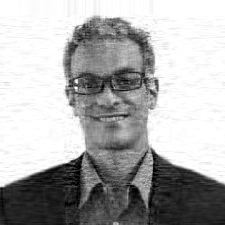

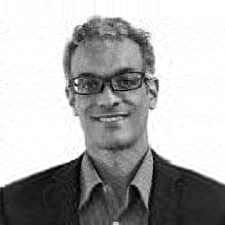

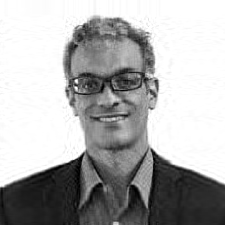

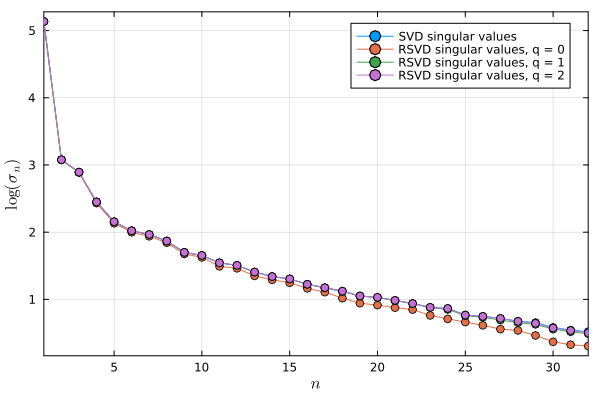

In [137]:
# print the reconstructed images
for i in eachindex(q_arr)
    Ã = U_all[i] * Diagonal(D_all[i]) * V_all[i]'
    display(Gray.(Ã))
end

display(fig)

### Quick note on how to control the parameters for desired performance

- $k$—Target rank: how many singular values/vectors you want to keep. Choose based on your application and properties of the data to process.
- $p$—Oversampling: typically 5-20. Too much oversampling does not improve the error significantly, and increases computation time.
- $q$—Power iterations: typically 1-5. More iterations improve accuracy, especially for matrices with slowly decaying singular values. 
- Random seed—Reproducibility: set a random seed for consistent results across runs.

---

**When to use RSVD?**

| Situation | RSVD | Classical SVD | 
|---------------|----------------|----------------|
|Very large matrices; you only need top‑$k$ | ✅ Best choice | Possible but slow|
|Streaming / out‑of‑core data | ✅ Good | Often impractical |
| Need all singular vectors exactly | Not ideal | ✅ Best choice | 
| Tall‑skinny / wide‑short matrices | ✅ Works well | Works, but often slower|
---

## 2. Tensor Networks (MPS/TT) for Data Compression 

> **Big picture.** 
>
> We want to store high‑dimensional data (a tensor) efficiently. **Tensor‑Train / Matrix‑Product State (TT/MPS)** rewrites one huge tensor as a *chain* of small 3‑way tensors (“cores”) with a modest **bond dimension** $\chi$. Memory drops from exponential to roughly linear in the number of modes.

---

A tensor with modes (dimensions) $n_1, n_2, \dots, n_N$ has $\prod_i n_i$ entries. For $n_i=d$, that’s $d^N$ — infeasible when $N$ grows.

> **Goal.** Represent the same object with **structured factors** so memory scales like $\mathcal O\big(N\,d\,\chi^2\big)$ (where ranks stay $\le \chi$), instead of $\mathcal O(d^N)$.

---

**What is TT/MPS?**

We factor the tensor into **cores** $G_k\in\mathbb{R}^{r_{k-1}\times n_k\times r_k}$ with TT‑ranks $r_0=1, r_N=1$:

$$
T[i_1,\dots,i_N] \;=\; \sum_{\alpha_1,\dots,\alpha_{N-1}}
G_1[1, i_1, \alpha_1]\,G_2[\alpha_1, i_2, \alpha_2]\,\cdots\,G_N[\alpha_{N-1}, i_N, 1].
$$

- Visible indices: $i_k$ (your data modes).
- Hidden indices: $\alpha_k$ (the **bonds**), with sizes $r_k$ a.k.a. **TT‑ranks**.

> **Memory head‑check.** If all $n_k\approx d$ and all $r_k\le \chi$, storing all cores costs $\approx N\,d\,\chi^2$ numbers.

---

**When does TT help?**

- Data has **local or low‑order structure** across modes (not all correlations are equally important).
- You’re happy with a **controlled approximation** (small error allowed).
- Classic examples: long sequences, images as multiway arrays, spatio‑temporal tensors, quantum states (where MPS was born).



---

### TT‑SVD (Oseledets): the standard tensor-train decomposition

> **Idea.** Repeatedly **reshape → SVD → truncate → reshape**, sweeping left→right. Keep just enough singular values to meet a user tolerance.

**Inputs**

- Tensor $T\in\mathbb{R}^{n_1\times\cdots\times n_N}$
- Either a **global tolerance** $\varepsilon$ (Frobenius) or a **rank cap** $r_{\max}$

**Outputs**

- Cores $\{G_k\}_{k=1}^N$ with TT‑ranks $1=r_0, r_1,\dots,r_{N-1}, r_N=1$

**Algorithm (left→right)**

1. Set $C\gets T$, $r_0\gets 1$.
2. For $k=1,\dots,N-1$:
   - Reshape $C$ to a matrix with **left** size $m=r_{k-1}n_k$ and **right** size $n=\prod_{j=k+1}^N n_j$: $C\in\mathbb{R}^{m\times n}.$
   - Compute the SVD: $C=U\,\Sigma\,V^\top$.
   - **Truncate**: choose the smallest $r_k$ such that the **discarded energy** $\sum_{i>r_k}\sigma_i^2$ is below a per‑step budget (see *Error control*), and also $r_k\le r_{\max}$ if provided.
   - Set core $G_k = \mathrm{reshape}(U_{:,1:r_k},\; r_{k-1},\, n_k,\, r_k)$.
   - Update $C \gets \Sigma_{1:r_k,1:r_k} V_{:,1:r_k}^\top$, which now has shape $r_k \times (n_{k+1}\cdots n_N)$.
3. Final core $G_N = \mathrm{reshape}(C,\; r_{N-1},\, n_N,\, 1).$

### Error control (standard bound)

If each step truncates so that the **local** discarded Frobenius norm is $\le \tau$, and you take $\tau = \varepsilon\,\|T\|_F/\sqrt{N-1}$, then the **global** error satisfies $\|T - \hat T\|_F \le \varepsilon\,\|T\|_F.$

> **Note.** This is the classic **TT‑SVD** (Oseledets, 2011) with *matrix SVDs only*. It’s the safest baseline. You can later swap each SVD with **RSVD** for speed if needed.



---

### Minimal, clear Julia implementation (TT‑SVD)

Self‑contained, no extra packages beyond `LinearAlgebra`. Handles either a global tolerance `eps` or a rank cap `rmax` (or both). Works for `Float64`/`Complex` data.

```julia
using LinearAlgebra

"""
    tt_svd(T; eps=nothing, rmax=typemax(Int))

Tensor‑Train SVD (Oseledets) — left→right sweep.
- `eps` (optional): global Frobenius tolerance. If provided, each step uses a per‑step budget `tau = eps*norm(T)/sqrt(d-1)`.
- `rmax` (optional): cap each TT‑rank.

Returns: `cores::Vector{Array{T,3}}` where `T=eltype(T)`; core k has shape `(r_{k-1}, n_k, r_k)`.
"""
function tt_svd(T::AbstractArray; eps=nothing, rmax::Int=typemax(Int))
    dims = size(T)
    d = length(dims)
    d ≥ 2 || error("Need at least a 2‑way tensor")

    # Per‑step tolerance to guarantee global bound (simple, standard split)
    normT = eps === nothing ? nothing : norm(T)
    tau2 = eps === nothing ? 0.0 : ( (eps * normT) / sqrt(d-1) )^2

    C = Array(T)  # working tensor (mutable)
    cores = Vector{Array{eltype(C),3}}(undef, d)
    r_prev = 1

    for k in 1:d-1
        nk = dims[k]
        m = r_prev * nk
        n = length(C) ÷ m
        M = reshape(C, m, n)

        U, S, V = svd(M; full=false)  # M ≈ U*Diagonal(S)*V'
        r = length(S)

        if eps !== nothing
            # keep the smallest r such that tail energy ≤ tau2
            e = cumsum(S.^2)
            total = e[end]
            # find minimal r so that discarded energy total - e[r] ≤ tau2
            r = searchsortedfirst(e, max(total - tau2, 0.0))
            r = min(r, length(S))
        end
        r = min(r, rmax)
        r = max(r, 1)

        U = U[:, 1:r]
        S = S[1:r]
        V = V[:, 1:r]

        cores[k] = reshape(U, r_prev, nk, r)
        C = Diagonal(S) * V'              # becomes r × (n_{k+1}…n_d)
        r_prev = r
    end

    # Last core: reshape C (r_{d-1} × n_d) → (r_{d-1}, n_d, 1)
    nd = dims[d]
    size(C,1) == r_prev || error("shape mismatch at last core")
    size(C,2) == nd      || error("unexpected trailing size; check dims")
    cores[d] = reshape(C, r_prev, nd, 1)

    return cores
end

"""
Reconstruct a full tensor from TT cores.
"""
function tt_reconstruct(cores::Vector{Array{T,3}}) where {T}
    d = length(cores)
    @assert d ≥ 2

    # Start with first core: (1, n1, r1) → matrix (n1 × r1)
    G1 = cores[1]
    M = reshape(G1, size(G1,2), size(G1,3))  # n1 × r1

    for k in 2:d-1
        G = cores[k]                          # (r_{k-1}, nk, r_k)
        # Matmul: (prev_n × r_{k-1}) * (r_{k-1} × nk*r_k) → (prev_n × nk*r_k)
        Gmat = reshape(permutedims(G, (1,2,3)), size(G,1), size(G,2)*size(G,3))
        M = reshape(M, :, size(G,1)) * Gmat
    end

    # Last core (r_{d-1}, n_d, 1)
    Gd = cores[end]
    Gdmat = reshape(permutedims(Gd, (1,2,3)), size(Gd,1), size(Gd,2)) # r_{d-1} × n_d
    M = reshape(M, :, size(Gd,1)) * Gdmat                             # → (n1…n_{d-1}) × n_d

    # Reshape back to full tensor dims
    n_all = map(k -> size(cores[k], 2), 1:d)
    return reshape(M, n_all...)
end

"""
Return TT‑ranks (r_0…r_N) from cores.
"""
function tt_ranks(cores)
    d = length(cores)
    r = Vector{Int}(undef, d+1)
    r[1] = size(cores[1], 1)
    for k in 1:d
        r[k+1] = size(cores[k], 3)
    end
    return r
end
```

> **Usage sketch.**
>
> ```julia
> X = randn(16, 16, 8, 8)               # example 4‑way tensor
> cores = tt_svd(X; eps=1e-3, rmax=64)  # decompose
> X̂ = tt_reconstruct(cores)            # reconstruct
> println("rel ‖X−X̂‖_F = ", norm(X - X̂)/norm(X))
> println("TT ranks = ", tt_ranks(cores))
> ```



---

### Practical guidance

- **Choose **``** first**, then use a gentle `rmax` as a guardrail. The algorithm picks the smallest ranks that meet the tolerance.
- **Scaling:** normalize your tensor (e.g., divide by its Frobenius norm) if you prefer an absolute `eps` value.
- **Numerical stability:** truncation via SVD is robust; no manual orthogonalization needed.
- **Performance:** for very large modes, you can accelerate each SVD with **RSVD** later (drop‑in replacement at the `svd(M)` line). Keep this baseline version for correctness.

> **Tip (copy/paste to your notebook).** The code block above is plain Markdown + Julia. You can copy it directly into a notebook cell. If your editor wraps lines, use the triple backticks exactly as shown.
